In [2]:
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
#import discretization_mod as dm
import os
import xml.etree.ElementTree as ET

import random
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import scipy as sp
from scipy import special
from scipy import stats
import xlwt

from scipy.optimize import minimize
from scipy import integrate


def f(x, func, kde, x_min, x_max):
    y, px, cov, p = func(x, kde, x_min, x_max)
    return cov

def grad(x, func, kde, x_min, x_max, alpha=1):
    y, px, cov, p = func(x, kde, x_min, x_max)
    step = alpha * px * (y[1:] - y[:-1]) * (y[1:] + y[:-1] - 2 * x) / 2
    return step

def cov_kde(x0, kde, x_min, x_max):
    p = np.zeros(len(x0) + 1)
    C = np.zeros(len(x0) + 1) 
    y = np.zeros(len(x0) + 1) 
    x_ext = sorted(np.append(x0, [x_min, x_max]))
    #len_p = len(kde_sample)
    #sum_C = np.sum(kde_sample)
    x_kde = lambda x: x * kde.evaluate(x)
    kde_func = lambda x: kde.evaluate(x)
    for i in range(len(x_ext)-1):
        #mask = np.where((x_ext[i] < kde_sample) & (kde_sample < x_ext[i+1])) #маска принадлежности отрезку
        p[i] = kde.integrate_box_1d(x_ext[i], x_ext[i + 1]) #integrate.quad(kde_func, x_ext[i], x_ext[i + 1])[0]#
                                                                    #len(kde_sample[mask]) / len_p
        C[i] = integrate.quad(x_kde, x_ext[i], x_ext[i + 1])[0] #np.sum(kde_sample[mask]) / len_p
        if p[i] == 0: 
            C[i] = 0
            p[i] = 1
    y = C / p
    px = kde.evaluate(x0)
    cov = np.linalg.norm(C / np.sqrt(p)) #/ sigma_kde
    return y, px, cov, p

def grad_descent(x, func, X):
    n_iter = 100
    ans = dict()
    for i in range(n_iter):
        x += grad(x, func, X, alpha=1)
        x = np.sort(x)
    ans['fun'] = -f(x, func, X)
    ans['x'] = x
    ans['success'] = True
    return ans

def exponential_discretisation(X, bits):
    std_W = np.std(X)
    max_W = np.fabs(X).max()
    x0 = (std_W / max_W) * 0.5**(bits-1)
    signs = np.sign(X)
    q_a = np.fabs(X.flatten()) / max_W
    n = 2 ** (bits - 1)
    q = 1 / x0 ** (1 / (n - 1))
    assert (x0 < 1)
    xx = [0] + [x0 * q ** i for i in range(n)]
    q_mean = np.zeros(q_a.size, dtype=np.float) + np.mean(q_a[q_a > xx[n - 1]])
    for i in range(len(xx) - 2):
        ii = np.logical_and(xx[i] < q_a, q_a <= xx[i + 1])
        q_mean[ii] = np.mean(q_a[ii])
    new_W = np.reshape(q_mean, X.shape) * signs * max_W
    return new_W, np.corrcoef(np.ravel(X), np.ravel(new_W))[1,0], np.array(xx) * max_W

def linear_discretization_ceil_nonzero(X, bitwidth):
    std_W = np.std(X)
    max_W = np.fabs(X).max()
    x0 = (std_W / max_W) * 0.5**(bitwidth-1)
    M = np.fabs(X).max()
    signs = np.sign(X)
    assert(x0 < 1)
    n = 2 ** (bitwidth - 1)# the number of gradation
    q = (1 - x0) / (n - 1)
    q_weights = np.fabs(X.flatten()) / M # between 0 and 1
    q_weights[abs(q_weights - 1.0) < 1e-7] = 1.0 - 1e-7 # remove maximal
    q_int = np.zeros(q_weights.size, dtype=np.int)
    q_int[q_weights <= x0] = 0
    q_int[q_weights > x0] = np.ceil((q_weights[q_weights > x0] - x0) / q)  # integers  
    x = x0 + q * q_int
    x = np.array(x, dtype=np.float16)
    xx = [0] + [x0 + q * i for i in range(n)]
    new_W = np.reshape(x, X.shape) * signs * M
    return new_W, np.corrcoef(np.ravel(X), np.ravel(new_W))[1,0], np.array(xx) * max_W

def results(kde, x0, x_min, x_max, func, bits, kde_std, ans_case='CG'):
    
    alpha = 1
    n_d = 2 ** bits
    
    fx = lambda x: -f(x, func, kde, x_min, x_max)
    gradx = lambda x: -grad(x, func, kde, x_min, x_max, alpha)
    
    tol_curr = 1e-4
    alpha = 1
    #ans = grad_descent(x0, func, X) 
    ans = minimize(fun=fx, x0=x0, jac=gradx, method='CG', tol=tol_curr)#, options={'gtol': 1e-1})
    #print(tol_curr, n_d, -ans['fun'], np.linalg.norm(gradx(ans['x'])) / alpha / n_d)
    print(ans['success'])
    solutions = ans['x']
    correlations = -ans['fun'] #/ np.std(X_small)
    gradients = np.linalg.norm(gradx(ans['x'])) / alpha / n_d
    return solutions, correlations, gradients

In [3]:
def change_weights(w, layer, grad_bit, x0=None):
    a = w[layer].copy()
    w1 = w.copy()
    a_rav = np.ravel(a)
    a_norm = a_rav #(a_rav - np.mean(a_rav)) / np.std(a_rav)
    a_min = a_norm.min()
    a_max = a_norm.max()
    if len(a_norm) > 10000:
        X_small = np.random.choice(a_norm, 10000, replace=False)
    else: X_small = a_norm    
        
    kde = stats.gaussian_kde(X_small, bw_method='scott')
    kde_x2 = lambda x: x ** 2 * kde.evaluate(x)
    kde_x = lambda x: x * kde.evaluate(x)
    int_x2 = integrate.quad(kde_x2, -np.inf, np.inf)[0]
    int_x = integrate.quad(kde_x, -np.inf, np.inf)[0]
    kde_std = (int_x2 - int_x ** 2) ** 0.5
    
    if x0 is None:
        x0 = np.linspace(a_min, a_max, 2 ** grad_bit + 1)[1:-1]
    else: 
        x0 = x0[1:-1]
    solutions, correlations, gradients = results(kde, x0, a_min, a_max, cov_kde, grad_bit, kde_std, ans_case='CG')
    print('layer [', layer,  ']=', correlations / kde_std)
    quant = np.sort(np.append(solutions, [a_max, a_min]))
    a_discr = a_rav.copy()
    a_norm_discr = a_norm.copy()
    x_discr = cov_kde(solutions, kde, a_min, a_max)[0]
    for i in range(len(quant) - 1):
        mask = np.logical_and(quant[i] <= a_norm, quant[i+1] >= a_norm)
        a_discr[mask] = x_discr[i] * np.std(a_rav) + np.mean(a_rav)
        a_norm_discr[mask] = x_discr[i]
    w1[layer] = a_discr.reshape(a.shape)
    print(np.corrcoef(a_discr, a_rav)[1,0])
    return w1

In [30]:
def change_all_weights(weights, grad_bit, layers_to_quant, init_discr='linear'):
    quant_weights = weights.copy()
    for layer in layers_to_quant:
        w_rav = np.ravel(quant_weights[layer])
        w_norm = (w_rav - np.mean(w_rav)) / np.std(w_rav)
        if len(w_norm) > 10000:
            w_small = np.random.choice(w_norm, 10000, replace=False)
        else: w_small = w_norm
        kde = stats.gaussian_kde(w_small, bw_method='scott')
        
        if init_discr == 'linear':
            weights_layer, corr, xx = linear_discretization_ceil_nonzero(w_norm, grad_bit)
        else:
            weights_layer, corr, xx = exponential_discretisation(w_norm, grad_bit)
            
        x0 = np.sort(np.append(xx, -xx[1:]))
        
        w_min = x0.min()
        w_max = x0.max()
        solutions, correlations, gradients = results(kde, x0[1:-1], w_min, w_max, cov_kde, grad_bit, kde_std=1, ans_case='CG')
        quant = np.sort(np.append(solutions, [w_max, w_min])) 
        w_discr = w_rav.copy()
        x_discr = cov_kde(solutions, kde, w_min, w_max)[0]
        for i in range(len(quant) - 1):
            mask = np.logical_and(quant[i] <= w_norm, quant[i+1] >= w_norm)
            w_discr[mask] = x_discr[i] * np.std(w_rav) + np.mean(w_rav)
        quant_weights[layer] = w_discr.reshape(quant_weights[layer].shape)
    return quant_weights

In [5]:
def load_batch_of_images(batch_size = 100, images_folder='imagenet/preprocessed images val', xml_folder='imagenet/xml val'):  
    jpeg_files = [file for file in os.listdir(images_folder)]
    random.shuffle(jpeg_files)
    jpeg_files_batch = jpeg_files[:batch_size]
    batch = []
    for i in range(batch_size):
        img = image.load_img(os.path.join('.', images_folder, jpeg_files_batch[i]), target_size=(224, 224))
        img = image.img_to_array(img)
        batch.append(img)

    batch = np.asarray(batch)
    #x = np.expand_dims(batch, axis=0)
    batch = preprocess_input(batch, mode='caffe')
    xml_files = [file.split('.')[0] + '.xml' for file in jpeg_files_batch]
    answers = []
    for i in range(batch_size):
        tree = ET.parse(os.path.join(xml_folder, xml_files[i]))
        root = tree.getroot()
        valid_value = root[5][0].text
        answers.append(valid_value)
    
    return batch, answers

def compute_accuracy_on_batch_of_images(batch, model, answers):  
    preds = model.predict(batch)
    # convert the probabilities to class labels
    labels = decode_predictions(preds)
    top1_correct = 0
    top5_correct = 0
    for i in range(len(batch)):
        if answers[i] == labels[i][0][0]:
            top1_correct += 1
        for k in range(5):
            if answers[i] in labels[i][k][0]:
                top5_correct += 1
                break
    top1_correct /= len(batch)
    top5_correct /= len(batch)
    #print("Top1:", top1_correct)
    #print("Top5:", top5_correct)
    
    return top1_correct, top5_correct

In [4]:
model = ResNet50(weights='imagenet')
weights = np.array(model.get_weights())

In [7]:
layers_to_quant = []
for i in range(len(weights)):
    if weights[i].ndim != 1:
        layers_to_quant.append(i)

In [22]:
weights_exp_5_bit = weights.copy()
for i in layers_to_quant:
    weights_exp_5_bit[i] = exponential_discretisation(weights_exp_5_bit[i], 5)[0]

In [23]:
weights_exp_4_bit = weights.copy()
for i in layers_to_quant:
    weights_exp_4_bit [i] = exponential_discretisation(weights_exp_4_bit[i], 4)[0]

In [45]:
weights_exp_6_bit = weights.copy()
for i in layers_to_quant:
    weights_exp_6_bit[i] = exponential_discretisation(weights_exp_6_bit[i], 6)[0]

In [25]:
weights_lin_5_bit = weights.copy()
for i in layers_to_quant:
    weights_lin_5_bit [i] = linear_discretization_ceil_nonzero(weights_lin_5_bit[i], 5)[0]

In [26]:
weights_lin_4_bit = weights.copy()
for i in layers_to_quant:
    weights_lin_4_bit [i] = linear_discretization_ceil_nonzero(weights_lin_4_bit[i], 4)[0]

In [48]:
weights_exp_kde_4_bit = change_all_weights(weights, 4, layers_to_quant, init_discr='exp')

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [49]:
weights_exp_kde_5_bit = change_all_weights(weights, 5, layers_to_quant, init_discr='exp')

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [60]:
len(np.unique(weights_exp_kde_5_bit[306]))

29

In [43]:
weights_exp_kde_6_bit = change_all_weights(weights, 6, layers_to_quant, init_discr='exp')

C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\user\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [37]:
weights_lin_kde_4_bit = change_all_weights(weights, 4, layers_to_quant)

In [38]:
weights_lin_kde_5_bit = change_all_weights(weights, 5, layers_to_quant)

In [18]:
batch, true_answers = load_batch_of_images(batch_size=100)

In [44]:
model.set_weights(weights)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model, true_answers)
print('no quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_exp_kde_4_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 4 bit exp kde quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_exp_kde_5_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 5 bit exp kde quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_exp_kde_6_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 6 bit exp kde quantization:', f'top1: {top1}, top5: {top5}')

no quantization: top1: 0.75, top5: 0.94
with 4 bit exp kde quantization: top1: 0.6, top5: 0.85
with 5 bit exp kde quantization: top1: 0.66, top5: 0.86
with 6 bit exp kde quantization: top1: 0.73, top5: 0.89


In [46]:
model1 = model
model1.set_weights(weights_exp_4_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 4 bit exp quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_exp_5_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 5 bit exp quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_exp_6_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 6 bit exp quantization:', f'top1: {top1}, top5: {top5}')

with 4 bit exp quantization: top1: 0.52, top5: 0.72
with 5 bit exp quantization: top1: 0.68, top5: 0.88
with 6 bit exp quantization: top1: 0.74, top5: 0.92


In [41]:
model1 = model
model1.set_weights(weights_lin_4_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 4 bit lin quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_lin_5_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 5 bit lin quantization:', f'top1: {top1}, top5: {top5}')

with 4 bit lin quantization: top1: 0.01, top5: 0.01
with 5 bit lin quantization: top1: 0.0, top5: 0.0


In [42]:
model1 = model
model1.set_weights(weights_lin_kde_4_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 4 bit lin kde quantization:', f'top1: {top1}, top5: {top5}')

model1 = model
model1.set_weights(weights_lin_kde_5_bit)
top1, top5 = compute_accuracy_on_batch_of_images(batch, model1, true_answers)
print('with 5 bit lin kde quantization:', f'top1: {top1}, top5: {top5}')

with 4 bit lin kde quantization: top1: 0.01, top5: 0.01
with 5 bit lin kde quantization: top1: 0.59, top5: 0.86


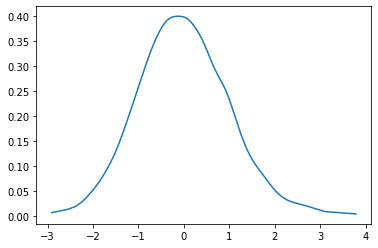

In [64]:
plt.plot(np.sort(w_small[::10]), kde.evaluate(np.sort(w_small[::10])))

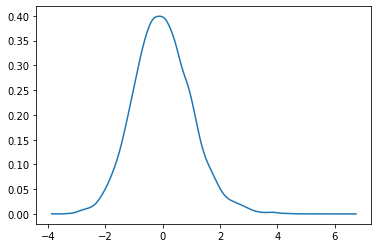

In [65]:
plt.plot(np.sort(w_small), kde.evaluate(np.sort(w_small)))